boto3 version 1.38.35<br>
pandas version 2.3.0<br>
matplotlib version 3.7.2<br>
seaborn version 0.13.2<br>

In [1]:
import boto3
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
MODEL_ID = "apac.anthropic.claude-3-5-sonnet-20241022-v2:0"

In [4]:
CSV_FILE_PATH = "hogehoge.csv"
MAX_SAMPLE_DATA_RECORD = 300
RANDOM_SEED = 42

In [5]:
DATA_DEFINITION = {"Region": "対象の不動産の土地の用途",
                   "Prefecture": "対象の不動産の都道府県名",
                   "Municipality": "対象の不動産の市区町村名",
                   "DistrictName": "対象の不動産の地域名",
                   "TradePrice": "対象の不動産の取引価格(単位は円)",
                   "Area": "対象の不動産の面積(単位は平方メートル)",
                   "result_PricePerArea": "対象の不動産の面積当たり取引価格(単位は円)"}

In [6]:
def define_system_prompt(user_prompt, data_define, csv_data, csv_file_path):
    system_prompt = """
    あなたは、経験豊富なデータサイエンティスト兼データモデラーです。
    ユーザーの要望に応じて、以下のツール群を適切に使い分けながら、必要な分析・設計・可視化・レビューを行ってください。
    ただし、ツール間には依存関係があります：

    1. `suggest_data_insight` は、CSVデータの傾向を把握したいときに使います。
    2. `generate_graph_program_code` は、`suggest_data_insight` によって得られた知見を元にグラフコードを生成するためのツールです。
    3. `review_program_code` は、`generate_graph_program_code` の出力を安全性チェックするために使います。
    4. `validate_data_schema_quality` は、データ定義と構造の設計をレビューしたい場合に使います。

    ツールを選び、必要に応じて複数のツールを順に使用して目的を達成してください。
    
    ユーザーの要望: {a}
    データ定義: {b}
    CSVデータ: {c}
    CSV_FILE_PATH = {d}
    """.format(a=user_prompt, b=json.dumps(data_define, ensure_ascii=False), c=csv_data, d=csv_file_path)
    return system_prompt

In [7]:
# データモデラーとしてデータの品質を確認するtoolを定義
def define_validate_data_schema_quality_tool():
    return {"toolSpec": {"name": "validate_data_schema_quality",
                         "description": "CSVデータとデータ定義からデータモデラーのようにデータ設計の妥当性や改善点を評価する際に用いる",
                         "inputSchema": {"json": {"type": "object",
                                                  "properties": {"data_column_definition": {"type": "object",  # このobject指定の仕組みをchatgptに質問する
                                                                                            "description": "カラム名とその意味を表すデータ定義"},
                                                                 "data_csv_format": {"type": "string",
                                                                                     "description": "対象データのCSV文字列"},
                                                                 "validation_summary": {"type": "string",
                                                                                        "description": "データ設計上の指摘や改善案や評価"}},
                                                  "required": ["data_column_definition",
                                                               "data_csv_format"]}}}}


# structured outputとLLMによる回答生成を利用するために上記のtoolを呼び出す関数
def validate_data_schema_quality(datas):
    system_prompt = """
    あなたは経験豊富なデータモデラー(データ設計者)です。
    以下のユーザー要望を踏まえつつ、データ定義とCSVデータをレビューして、データ設計上のイマイチな点・改善すべき点をフィードバックしてください。

    - 型や粒度の不一致、重複カラム、曖昧なカラム名、非正規化、ユースケースに合ってない構造、カラム間の依存関係の問題などに注目してください。
    - レビュー結果は自然言語で「何が問題で、どう改善できるか」を明確に述べてください。
    
    ユーザー要望 : {a}
    データ定義(JSON) : {b}
    csvデータ : {c}
    """.format(a=datas["user_prompt"], b=json.dumps(datas["data_define"], ensure_ascii=False), c=datas["csv_data"])
    claude_input_message = [{"role": "user",
                             "content": [{"text": system_prompt}]}]
    response = datas["bedrock_client"].converse(modelId=datas["model_id"],
                                                messages=claude_input_message,
                                                inferenceConfig={"temperature": 0.2},
                                                toolConfig={"tools": [datas["agent_tool_dict"]["validate_data"]],
                                                            "toolChoice": {"tool": {"name": "validate_data_schema_quality"}}})
    response_validation = response["output"]["message"]["content"][0]["toolUse"]["input"]["validation_summary"]
    return response_validation

In [8]:
# データサイエンティストとしての知見を提示するtoolを定義
def define_suggest_data_insight_tool():
    return {"toolSpec": {"name": "suggest_data_insight",
                         "description": "CSVデータとユーザープロンプトからデータサイエンティストのように知見と仮説を導くツール",
                         "inputSchema": {"json": {"type": "object",
                                                  "properties": {"available_data_columns": {"type": "array",
                                                                                            "items": {"type": "string"},
                                                                                            "description": "利用可能なデータカラム名のリスト"},
                                                                 "user_intent": {"type": "string",
                                                                                 "description": "ユーザーの自然言語によるグラフ作成の要望"},
                                                                 "data_csv_format": {"type": "string",
                                                                                     "description": "対象データのCSV文字列"},
                                                                 "insight_summary": {"type": "string",
                                                                                     "description": "知見と仮説(Chain of Thought)"}},
                                                  "required": ["available_data_columns",
                                                               "user_intent",
                                                               "data_csv_format"]}}}}


# 上記のtoolを呼び出して利用する関数
def suggest_data_insight(datas):
    system_prompt = """
    あなたは経験豊富なデータサイエンティストです。
    以下のCSVデータとデータ定義、およびユーザー要望に基づいて、データに関する「知見(Insight)」や「仮説(Hypothesis)」を導いてください。
    
    - 特に、傾向・相関・外れ値・偏りなどを発見してください。
    - ユーザーの分析目的に寄り添い、Chain of Thought(思考の流れ)を明示してください。
    - 出力形式は自然言語の解説で構いません。

    ユーザー要望 : {a}
    データ定義(JSON) : {b}
    csvデータ : {c}
    """.format(a=datas["user_prompt"], b=json.dumps(datas["data_define"], ensure_ascii=False), c=datas["csv_data"])
    claude_input_message = [{"role": "user",
                             "content": [{"text": system_prompt}]}]
    response = datas["bedrock_client"].converse(modelId=datas["model_id"],
                                                messages=claude_input_message,
                                                inferenceConfig={"temperature": 0.2},
                                                toolConfig={"tools": [datas["agent_tool_dict"]["suggest_insight"]],
                                                            "toolChoice": {"tool": {"name": "suggest_data_insight"}}})
    # print("*****", response, sep="\n")
    response_insight = response["output"]["message"]["content"][0]["toolUse"]["input"]["insight_summary"]
    return response_insight

In [9]:
# グラフ作成のコードを生成するtoolを定義
def define_generate_graph_program_code_tool():
    return {"toolSpec": {"name": "generate_graph_program_code",
                        "description": "データサイエンティストの知見に合わせて、pandasとmatplotlibで適切なグラフを作成するPythonコードを生成するツール",
                        "inputSchema": {"json": {"type": "object",
                                                 "properties": {"available_data_columns": {"type": "array",
                                                                                           "items": {"type": "string"},
                                                                                           "description": "利用可能なデータカラム名のリスト"},
                                                                "user_intent": {"type": "string",
                                                                                "description": "ユーザーの自然言語によるグラフ作成の要望"},
                                                                "data_csv_format": {"type": "string",
                                                                                    "description": "対象データのCSV文字列"},
                                                                "generate_code": {"type": "string",
                                                                                  "description": "グラフ作成のためのPythonコード"}},
                                                 "required": ["available_data_columns",
                                                              "user_intent",
                                                              "data_csv_format"]}}}}


# 上記のtoolを呼び出して利用する関数
def generate_graph_code(datas):
    system_prompt = """
    以下の知見と仮説、およびCSVデータとデータ定義を踏まえて、最も適切なmatplotlibのグラフを作成するPythonコードを作成してください。
    - 知見と仮設は、データサイエンスの専門家が導いたものです。グラフの種類、軸、集約方法はこの知見を反映してください。
    - グラフはpngファイルで保存はせず、plt.show()でそのまま表示してください。
    - 必ず次の変数 `CSV_FILE_PATH` を使って、文字コードは utf-8 でCSVファイルを読み込んでください。
    - pandasの `pd.read_csv(CSV_FILE_PATH, encoding='utf-8')` のように使用してください。
    - seabornを利用する場合は文字化けを避けるために下記の3点をコードに盛り込んでください。
      * from matplotlib.font_manager import FontProperties
      * jp_font = FontProperties(fname='/usr/share/fonts/ipa-gothic-fonts/ipag.ttf')
      * 日本語のタイトルやラベルや目盛りや凡例が含まれる場合は、plt.title("タイトル", fontproperties=jp_font)のように、全ての plt.title, plt.xlabel, plt.ylabel, plt.xticks, plt.yticks, ax.set_title 等に適用してください。

    CSV_FILE_PATH = {d}

    ユーザー要望 : {e}
    知見と仮設 : {a}
    データ定義(JSON) : {b}
    csvデータ : {c}
    """.format(a=datas["insight_summary"], b=json.dumps(datas["data_define"], ensure_ascii=False), c=datas["csv_data"], d=datas["csv_file_path"], e=datas["user_prompt"])
    claude_input_message = [{"role": "user",
                             "content": [{"text": system_prompt}]}]
    response = datas["bedrock_client"].converse(modelId=datas["model_id"],
                                                messages=claude_input_message,
                                                inferenceConfig={"temperature": 0.2},
                                                toolConfig={"tools": [datas["agent_tool_dict"]["generate_code"]],
                                                            "toolChoice": {"tool": {"name": "generate_graph_program_code"}}})
    # print("*****", response, sep="\n")
    response_code = response["output"]["message"]["content"][0]["toolUse"]["input"]["generate_code"]
    return response_code

In [10]:
# 生成されたコードをレビューするtoolを定義
def define_review_program_code_tool():
    return {"toolSpec": {"name": "review_program_code",
                         "description": "生成されたPythonコードの安全性を判定し、「実行OK」か「実行NG」を返すツール",
                         "inputSchema": {"json": {"type": "object",
                                                  "properties": {"code": {"type": "string",
                                                                          "description": "レビュー対象の生成されたPythonコード"},
                                                                 "code_check_flag": {"type": "string",
                                                                                     "enum": ["実行OK", "実行NG"],
                                                                                     "description": "生成されたPythonコードの安全性"}},
                                                  "required": ["code"]}}}}


# 上記のtoolを呼び出して利用する関数
def review_code(datas):
    system_prompt = """
    以下のPythonコードの安全性をチェックしてください。危険な処理が無ければ「実行OK」を返してください。
    
    pythonコード：{a}
    """.format(a=datas["generated_code"])
    claude_input_message = [{"role": "user",
                             "content": [{"text": system_prompt}]}]
    response = datas["bedrock_client"].converse(modelId=datas["model_id"],
                                                messages=claude_input_message,
                                                inferenceConfig={"temperature": 0.2},
                                                toolConfig={"tools": [datas["agent_tool_dict"]["review_code"]],
                                                            "toolChoice": {"tool": {"name": "review_program_code"}}})
    # print("*****", response, sep="\n")
    response_review_flag = response["output"]["message"]["content"][0]["toolUse"]["input"]["code_check_flag"]
    return response_review_flag

In [11]:
def handle_calling_agent_tool(next_tool_name, next_tool_use_id, var_data_dict):
    if next_tool_name == "validate_data_schema_quality":
        var_data_dict["validation_summary"] = validate_data_schema_quality(datas=var_data_dict)
        print("*****", var_data_dict["validation_summary"], sep="\n")
        var_data_dict["message_history"].append({"content": [{"toolResult": {"toolUseId": next_tool_use_id,
                                                                             "content": [{"text": var_data_dict["validation_summary"]}]}}],
                                                 "role": "user"})
    elif next_tool_name == "suggest_data_insight":
        var_data_dict["insight_summary"] = suggest_data_insight(datas=var_data_dict)
        print("*****", var_data_dict["insight_summary"], sep="\n")
        var_data_dict["message_history"].append({"content": [{"toolResult": {"toolUseId": next_tool_use_id,
                                                                             "content": [{"text": var_data_dict["insight_summary"]}]}}],
                                                 "role": "user"})
    elif next_tool_name == "generate_graph_program_code":
        var_data_dict["generated_code"] = generate_graph_code(datas=var_data_dict)
        print("*****", var_data_dict["generated_code"], sep="\n")
        var_data_dict["message_history"].append({"content": [{"toolResult": {"toolUseId": next_tool_use_id,
                                                                             "content": [{"text": var_data_dict["generated_code"]}]}}],
                                                 "role": "user"})
    elif next_tool_name == "review_program_code":
        var_data_dict["code_check_flag"] = review_code(datas=var_data_dict)
        print("*****", var_data_dict["code_check_flag"], sep="\n")
        var_data_dict["message_history"].append({"content": [{"toolResult": {"toolUseId": next_tool_use_id,
                                                                             "content": [{"text": var_data_dict["code_check_flag"]}]}}],
                                                 "role": "user"})
        if var_data_dict["code_check_flag"] == "実行OK":
            exec(var_data_dict["generated_code"])
    else:
        var_data_dict["not_expected_agent_tool_flag"] = True
    return var_data_dict

In [12]:
def call_claude_LLM_agent(model_id, data_define, csv_file_path, user_prompt, max_sample_size, random_seed):
    var_data_dict = {}
    var_data_dict["data_define"] = data_define
    var_data_dict["csv_file_path"] = csv_file_path
    var_data_dict["user_prompt"] = user_prompt
    var_data_dict["model_id"] = model_id
    var_data_dict["bedrock_client"] = boto3.client("bedrock-runtime",
                                                   region_name="ap-northeast-1")
    df_data = pd.read_csv(filepath_or_buffer=csv_file_path,
                          encoding="utf-8")
    sampled_df_data = df_data.sample(n=min(len(df_data), max_sample_size),
                                     random_state=random_seed)
    var_data_dict["csv_data"] = sampled_df_data.to_csv(index=False,
                                                       encoding="utf-8")
    # LLMエージェントが利用出来るツールを設定
    var_data_dict["agent_tool_dict"] = {"validate_data": define_validate_data_schema_quality_tool(),
                                        "suggest_insight": define_suggest_data_insight_tool(),
                                        "generate_code": define_generate_graph_program_code_tool(),
                                        "review_code": define_review_program_code_tool()}
    # 最初のLLM対応用のシステムプロンプトを設定
    system_prompt = define_system_prompt(user_prompt=var_data_dict["user_prompt"],
                                         data_define=var_data_dict["data_define"],
                                         csv_data=var_data_dict["csv_data"],
                                         csv_file_path=var_data_dict["csv_file_path"])
    var_data_dict["message_history"] = [{"content": [{"text": system_prompt}],
                                         "role": "user"}]
    # LLMエージェントを呼び出す
    var_data_dict["validation_summary"] = None
    var_data_dict["insight_summary"] = None
    var_data_dict["generated_code"] = None
    var_data_dict["code_check_flag"] = None
    while True:
        # 普通のLLM対応
        response = var_data_dict["bedrock_client"].converse(modelId=var_data_dict["model_id"],
                                                            messages=var_data_dict["message_history"],
                                                            inferenceConfig={"temperature": 0.2},
                                                            toolConfig={"tools": list(var_data_dict["agent_tool_dict"].values())})
        # print(response)
        print("*****", response["output"]["message"]["content"][0]["text"], sep="\n")
        # LLM対応の回答を収集
        var_data_dict["message_history"].append(response["output"]["message"])
        response_content = response["output"]["message"]["content"]
        stop_reason = response.get("stopReason")
        # tool_useの利用を促してきたかどうかを判断
        if stop_reason == "tool_use":  # tool_useの利用を促してきた場合
            content_in_tool_use = None
            # tool_useの利用に必要なデータを収集
            for content in response_content:
                if "toolUse" in content.keys():
                    content_in_tool_use = content["toolUse"]
                    break
                else:
                    continue
            if not content_in_tool_use:
                break
            next_tool_name = content_in_tool_use["name"]
            next_tool_use_id = content_in_tool_use["toolUseId"]
            # tool_useで促されたtoolを実行
            var_data_dict["not_expected_agent_tool_flag"] = False
            var_data_dict = handle_calling_agent_tool(next_tool_name=next_tool_name,
                                                      next_tool_use_id=next_tool_use_id,
                                                      var_data_dict=var_data_dict)
            if var_data_dict["not_expected_agent_tool_flag"]:
                print("定義していないtoolをLLMは選択しました。")
                break
        else:  # tool_useの利用を促さなかった場合
            print("*****", "LLMエージェントの処理は想定通りに完了しました。", sep="\n")
            break
    return None

*****
ユーザーの要望に応えるため、以下の手順で分析を進めていきます：

1. まず `suggest_data_insight` を使用して価格に関する傾向を分析
2. 得られた知見に基づいて `generate_graph_program_code` でグラフを作成
3. 生成されたコードの安全性を `review_program_code` でチェック

では、順番に実行していきましょう。

まず、価格の傾向を分析します：
*****
データの分析から以下の知見と仮説が導かれます：

1. 価格帯の分布と特徴
- 取引価格の範囲は4,000万円から36億円と非常に広い
- 中央値は約3.5億円付近
- 特に高額物件（10億円以上）が複数存在し、その多くが南青山や元麻布に位置している

2. 地域別の価格傾向
- 最も高額な取引が見られる地域：
  * 元麻布（最高36億円）
  * 南青山（最高27億円）
  * 麻布十番（15億円）
- 比較的手頃な価格帯が多い地域：
  * 白金（4,000万円～2億円）
  * 三田（1.2億円～4.7億円）

3. 面積当たり単価（result_PricePerArea）の分析
- 平均的な単価は250～300万円/㎡
- 最高値：麻布十番（1,250万円/㎡）
- 最低値：白金（80万円/㎡）
- 同じ地域でも大きな価格差が存在

4. 面積と価格の関係
- 基本的に面積が大きいほど総額も高くなる傾向
- ただし、同じ面積でも立地により2倍以上の価格差が生じるケースも

仮説：
1. 元麻布、南青山などの特定エリアは富裕層向けの高級住宅地として確立されており、プレミアム価格が形成されている
2. 白金、三田などは比較的新しい住宅地として開発が進み、より幅広い層向けの価格帯を形成している
3. 特に高額な物件は、希少性の高い大型物件や特別な眺望・利便性を持つ物件である可能性が高い
*****
この分析結果に基づき、以下の2つの重要な視点でグラフを作成することを提案します：
1. 地域別の価格分布を把握するためのボックスプロット
2. 面積と価格の関係を可視化する散布図
*****
import pandas as pd
import matplotlib.pyplot as plt
import seaborn a

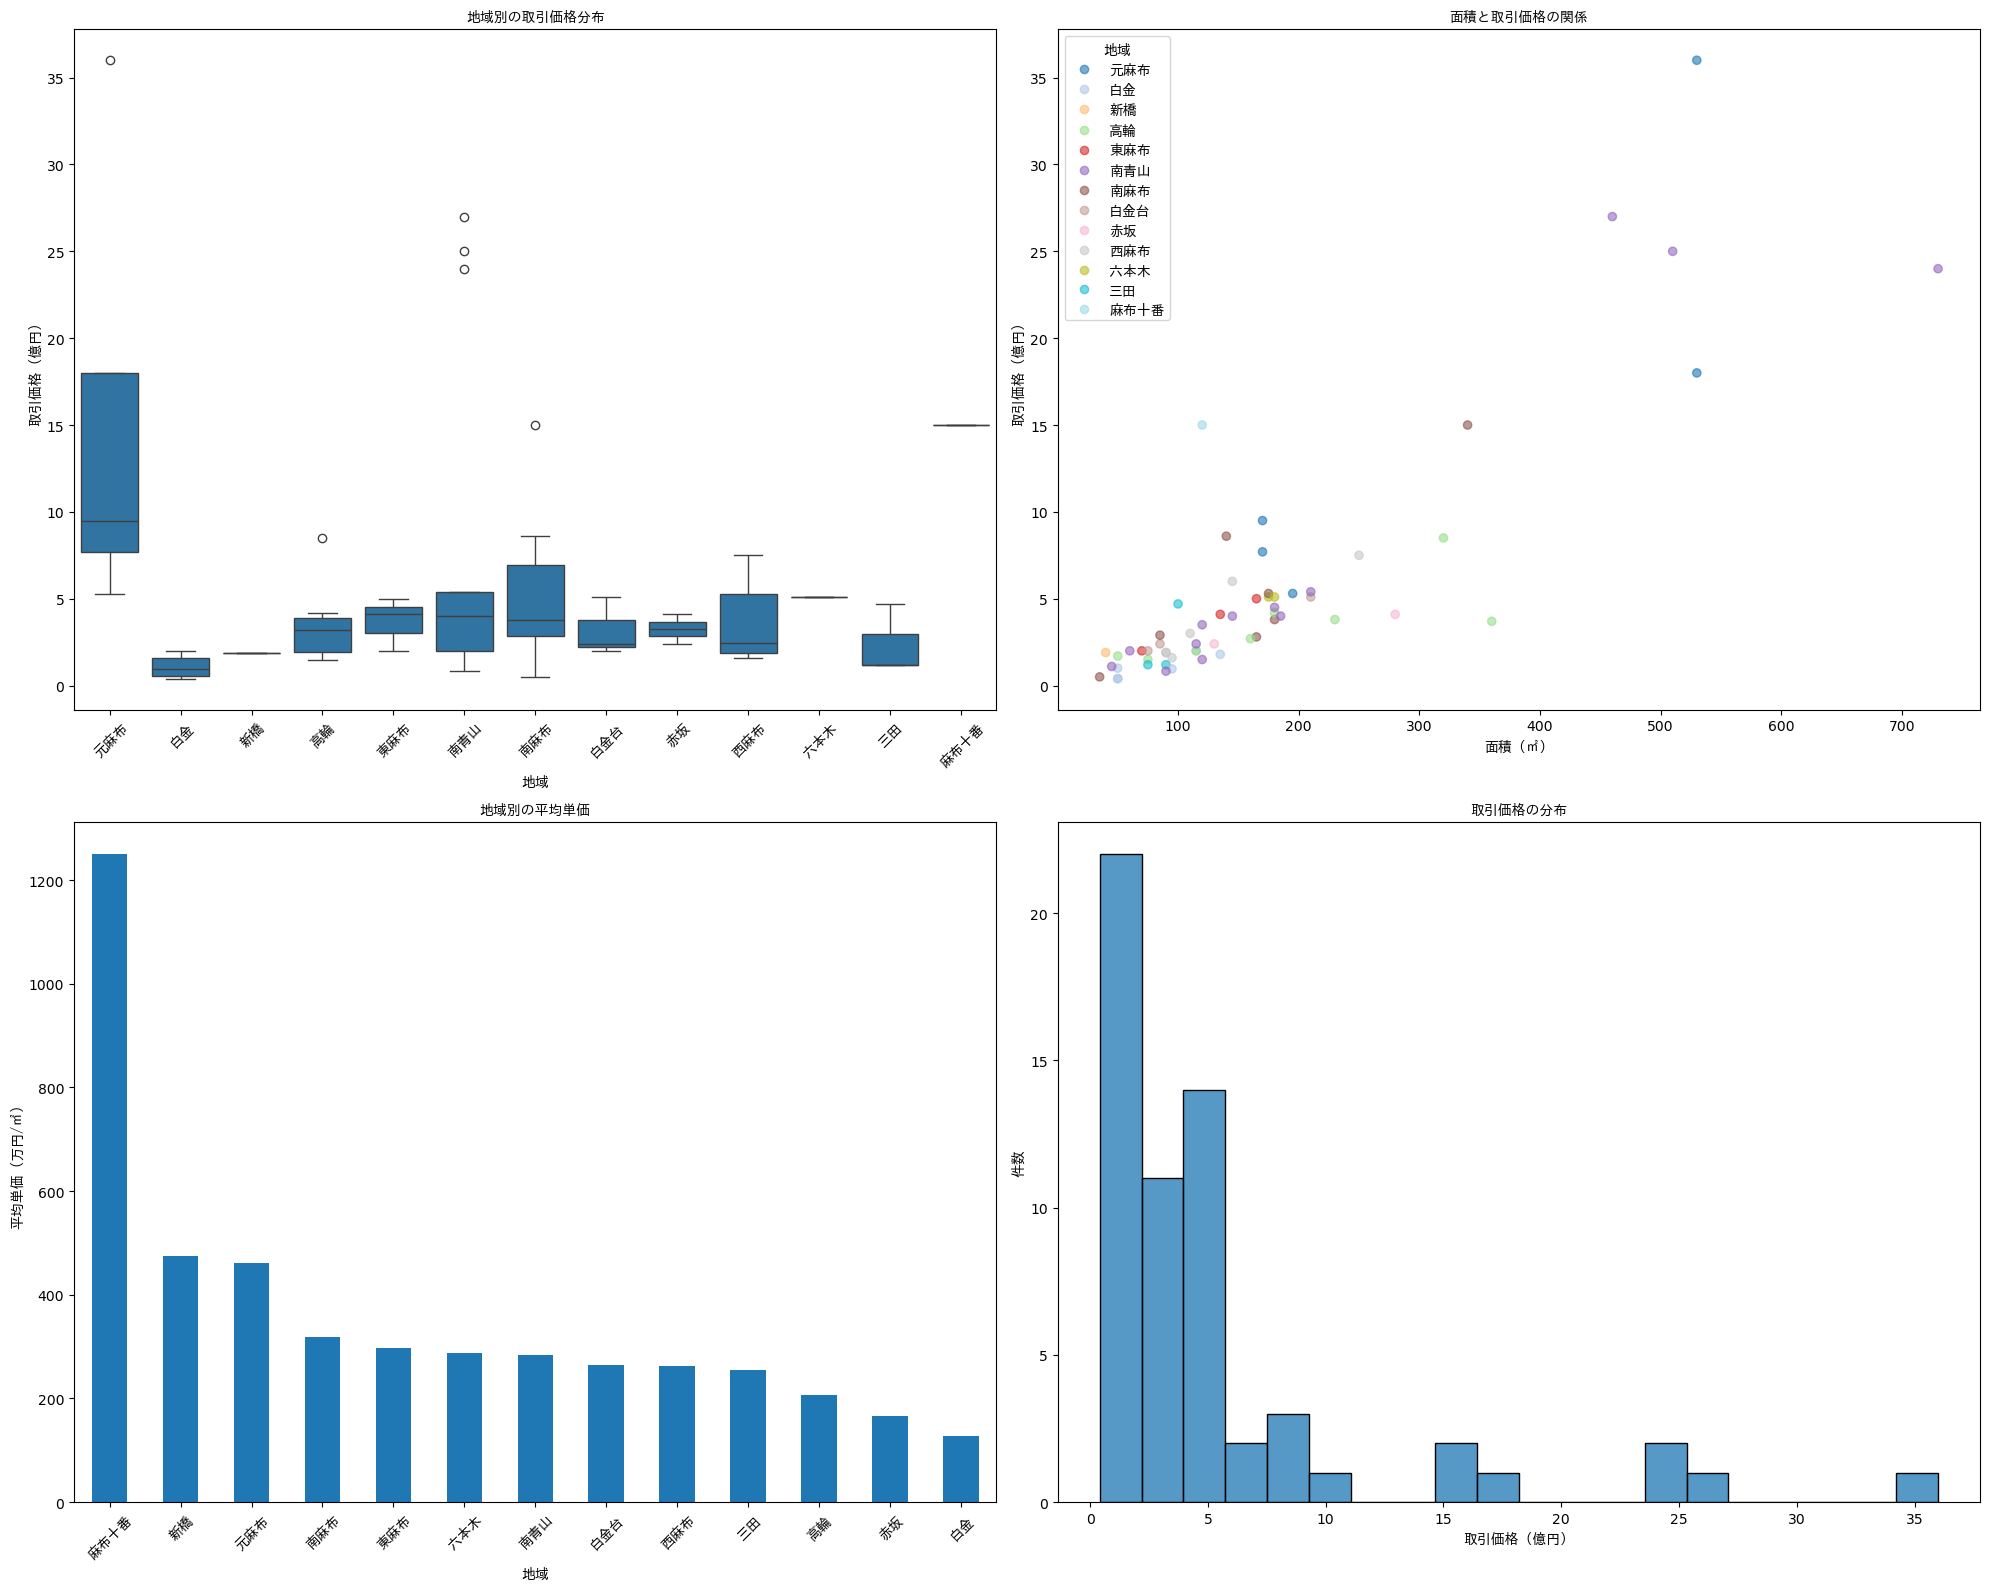

*****
生成されたコードは安全であり、以下の4つの視点から価格傾向を可視化します：

1. 地域別の取引価格分布（箱ひげ図）
   - 各地域の価格帯の範囲や中央値を比較可能
   - 外れ値となる高額物件も確認可能

2. 面積と取引価格の関係（散布図）
   - 面積と価格の相関関係を地域別に色分けして表示
   - 同じ面積でも地域による価格差を視覚的に確認可能

3. 地域別の平均単価（バープロット）
   - 各地域の平方メートルあたりの平均価格を比較
   - 地域による単価の違いを明確に表示

4. 取引価格の分布（ヒストグラム）
   - 価格帯ごとの物件数を表示
   - 最も取引の多い価格帯を把握可能

これらのグラフにより、港区の不動産価格の傾向を多角的に理解することができます。特に地域による価格差や、面積と価格の関係性が明確に可視化されています。
*****
LLMエージェントの処理は想定通りに完了しました。


In [13]:
USER_PROMPT = "価格の傾向を知りたい。"
# USER_PROMPT = "データ設計の観点でアドバイス頂きたい。"
call_claude_LLM_agent(model_id=MODEL_ID,
                      data_define=DATA_DEFINITION,
                      csv_file_path=CSV_FILE_PATH,
                      user_prompt=USER_PROMPT,
                      max_sample_size=MAX_SAMPLE_DATA_RECORD,
                      random_seed=RANDOM_SEED)